# EDA

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Useful line of code to set the display option so we could see all the columns/rows in pd dataframe
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [9]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
DATA = ROOT / "data"
INTERIM_DATA = DATA / "interim"

In [10]:
trx = pd.read_parquet(INTERIM_DATA/"transactions.parquet.gzip")

In [11]:
trx.head()

,customer_id,tx_datetime,tx_amount,sector_id,tx_fraud,tx_amount_log,day_of_week,hour,month,is_month_start,is_month_end,is_weekend
0,2541,2023-01-01 00:21:42,499.210846,11,0,6.215030,6,0,1,1,0,1
1,1735,2023-01-01 00:21:59,58.824293,3,0,4.091412,6,0,1,1,0,1
2,669,2023-01-01 00:36:40,91.967189,12,0,4.532247,6,0,1,1,0,1
3,4235,2023-01-01 00:51:34,836.571053,16,0,6.730506,6,0,1,1,0,1
4,2162,2023-01-01 01:15:23,1537.707662,19,0,7.338698,6,1,1,1,0,1


In [12]:
trx['tx_fraud'].value_counts(normalize=True)

tx_fraud
0    0.996927
1    0.003073
Name: proportion, dtype: float64

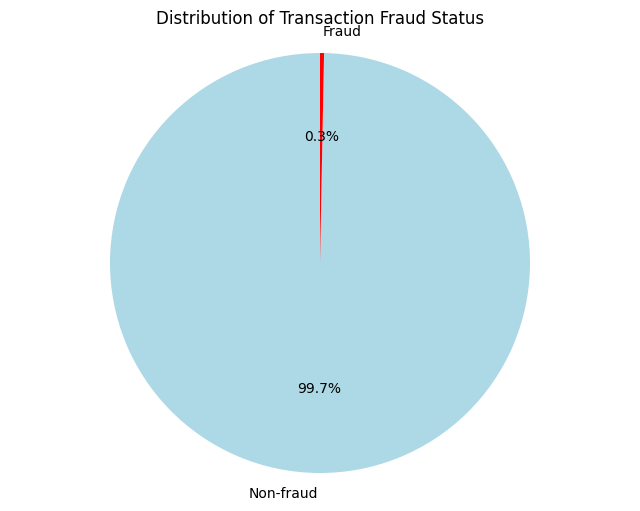

In [13]:
plt.figure(figsize=(8,6))
fraud_counts = trx['tx_fraud'].value_counts()
labels = ['Non-fraud', 'Fraud'] if 0 in fraud_counts else ['Fraud']

plt.pie(fraud_counts.values, 
        labels=labels, 
        autopct='%1.1f%%',
        startangle=90,
        colors=['lightblue', 'red'])

plt.title('Distribution of Transaction Fraud Status')
plt.axis('equal') 
plt.show()

#### Observations

* Dataset is highly imbalanced (`0.3%` of fraud transactions)

### Total spending by sector

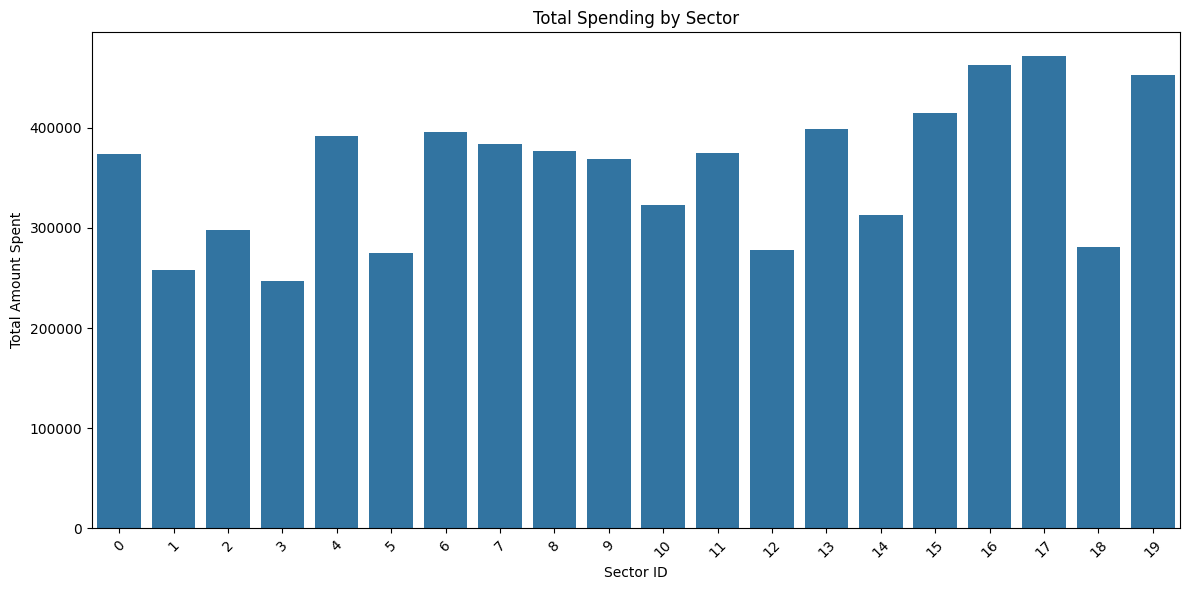

In [14]:
sector_spending = trx.groupby('sector_id')['tx_amount_log'].sum().reset_index()

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=sector_spending, x='sector_id', y='tx_amount_log')
plt.title('Total Spending by Sector')
plt.xlabel('Sector ID')
plt.ylabel('Total Amount Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distributions by sector

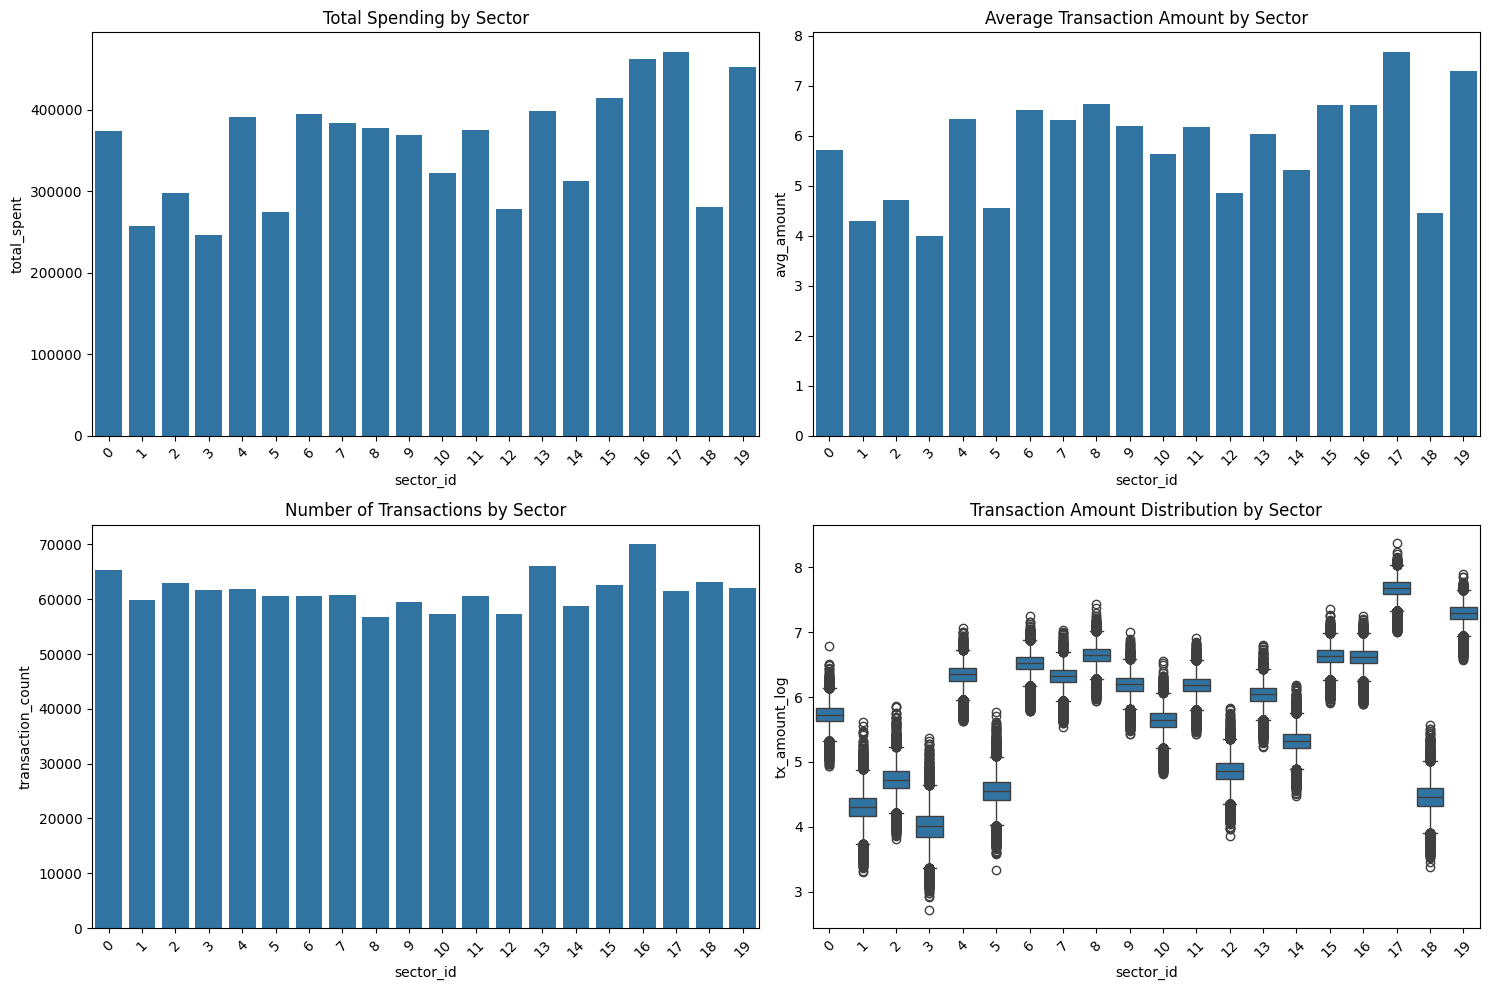

In [15]:
sector_summary = trx.groupby('sector_id').agg({
    'tx_amount_log': ['sum', 'mean', 'count']
}).round(2)
sector_summary.columns = ['total_spent', 'avg_amount', 'transaction_count']
sector_summary = sector_summary.reset_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.barplot(data=sector_summary, x='sector_id', y='total_spent', ax=axes[0,0])
axes[0,0].set_title('Total Spending by Sector')
axes[0,0].tick_params(axis='x', rotation=45)

sns.barplot(data=sector_summary, x='sector_id', y='avg_amount', ax=axes[0,1])
axes[0,1].set_title('Average Transaction Amount by Sector')
axes[0,1].tick_params(axis='x', rotation=45)

sns.barplot(data=sector_summary, x='sector_id', y='transaction_count', ax=axes[1,0])
axes[1,0].set_title('Number of Transactions by Sector')
axes[1,0].tick_params(axis='x', rotation=45)

sns.boxplot(data=trx, x='sector_id', y='tx_amount_log', ax=axes[1,1])
axes[1,1].set_title('Transaction Amount Distribution by Sector')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Fraud transactions by sector

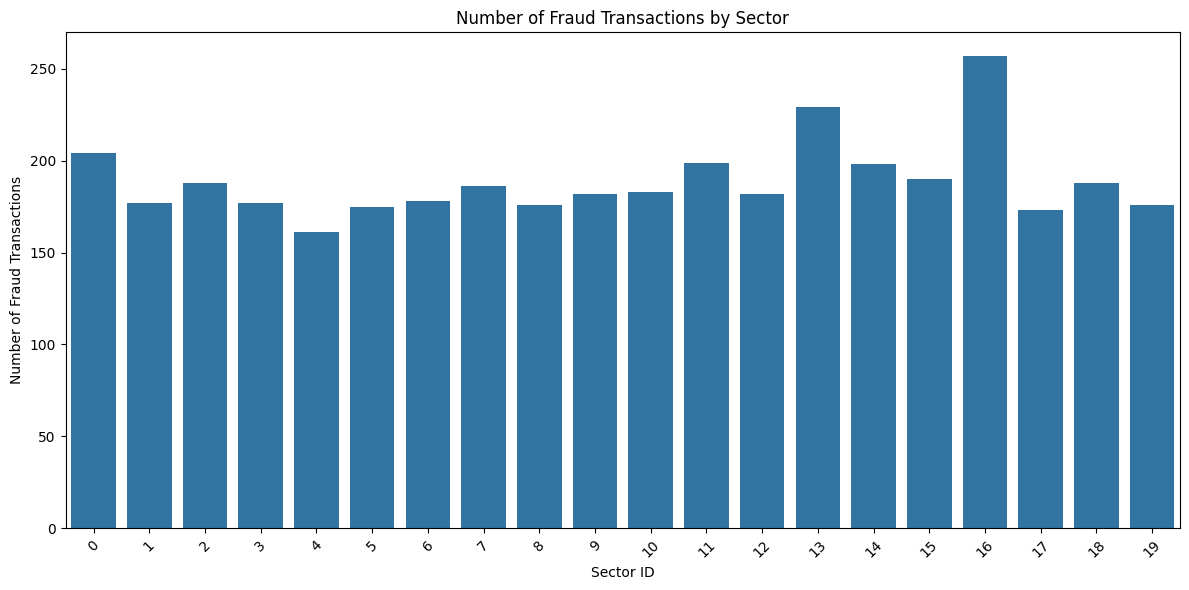

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fraud_by_sector = trx.groupby('sector_id')['tx_fraud'].sum().reset_index()
fraud_by_sector.columns = ['sector_id', 'fraud_count']

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_sector, x='sector_id', y='fraud_count')
plt.title('Number of Fraud Transactions by Sector')
plt.xlabel('Sector ID')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distribution of fraud / non-fraud transactions by sector

<Figure size 1200x600 with 0 Axes>

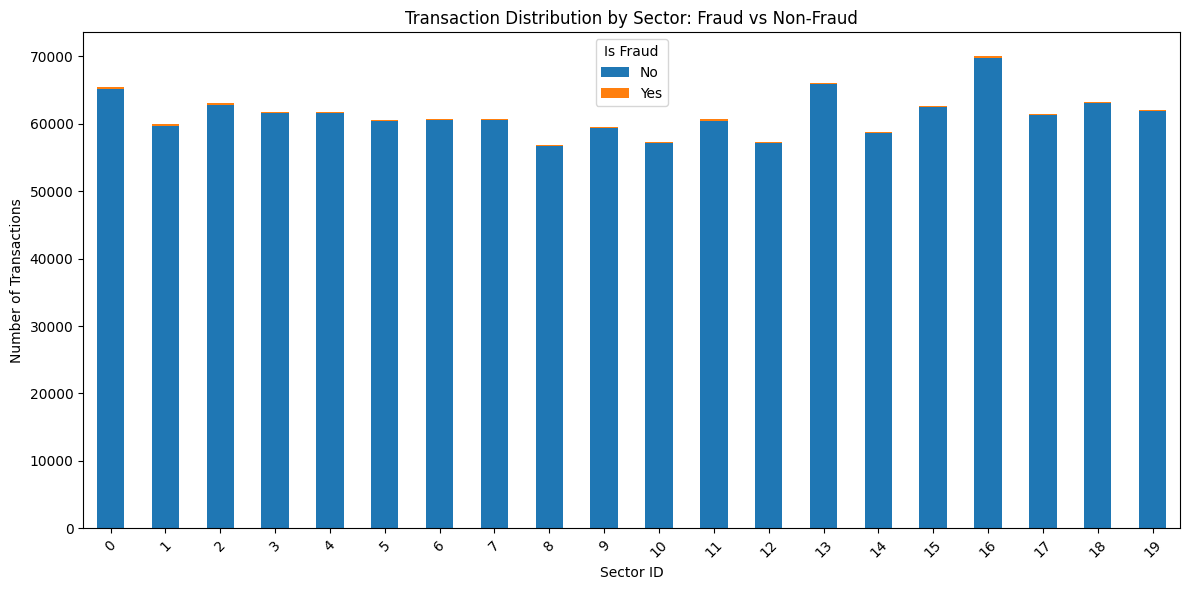

In [17]:
fraud_pivot = trx.groupby(['sector_id', 'tx_fraud']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
fraud_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Transaction Distribution by Sector: Fraud vs Non-Fraud')
plt.xlabel('Sector ID')
plt.ylabel('Number of Transactions')
plt.legend(title='Is Fraud', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Fraud transaction relations

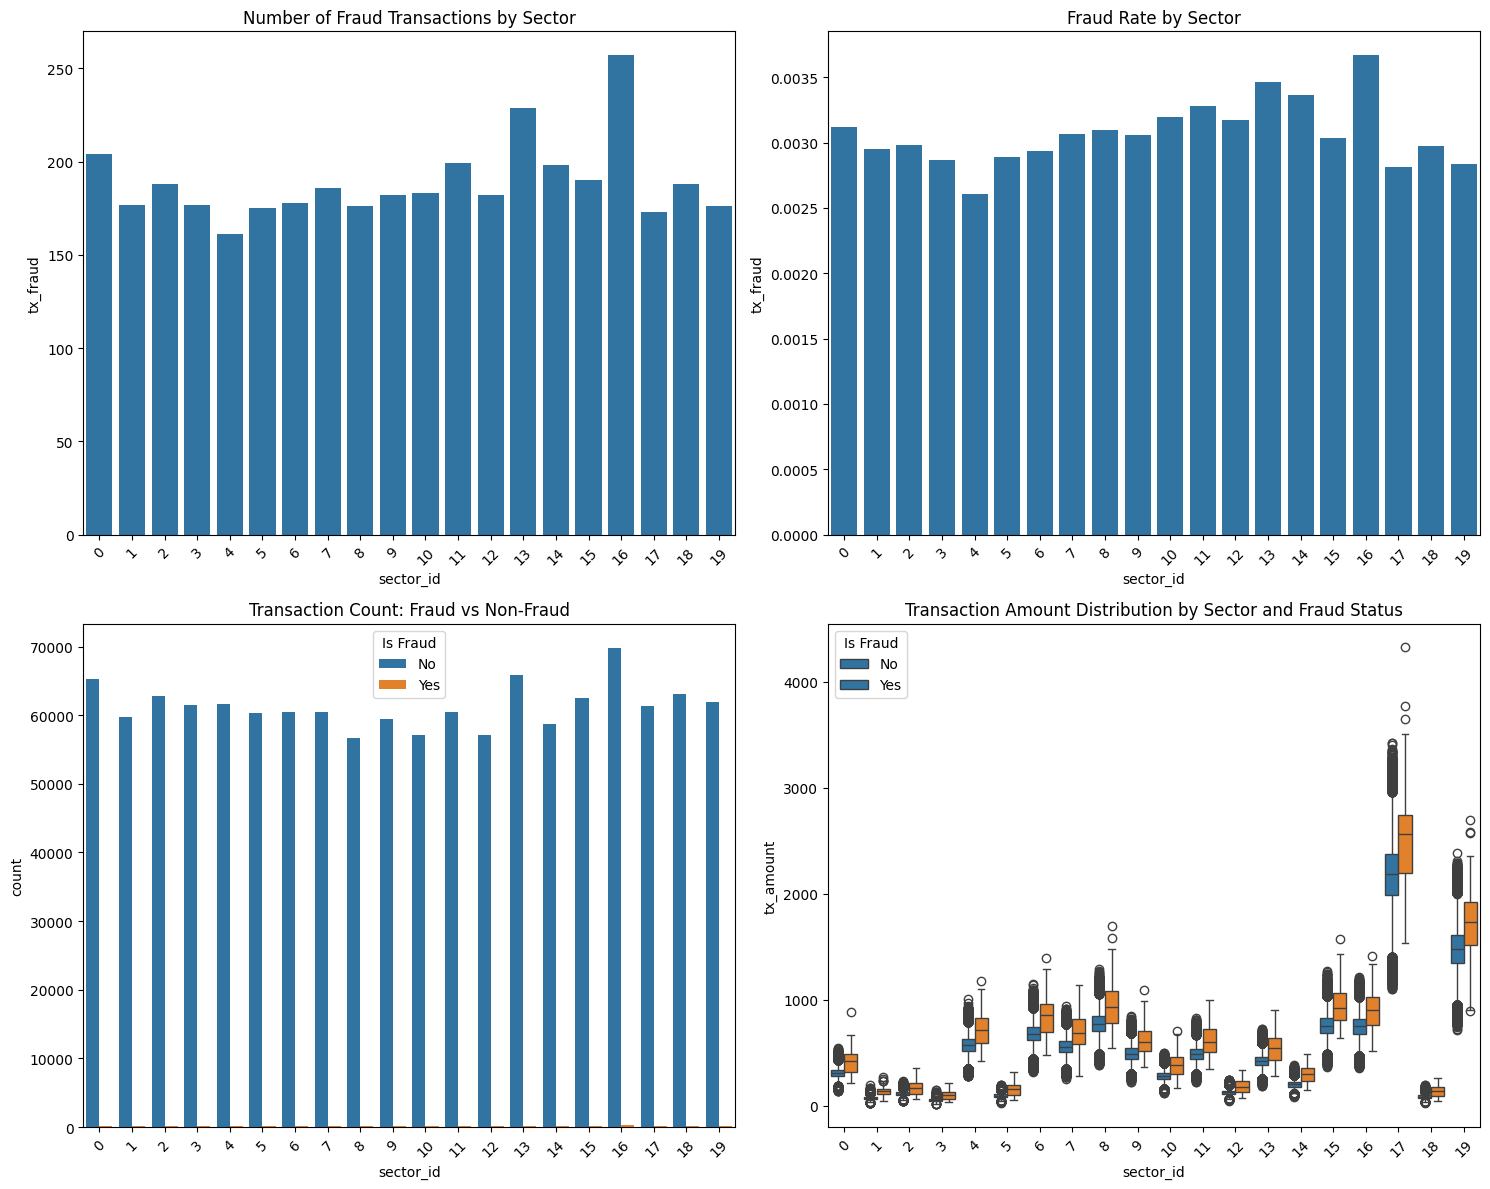

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

fraud_count = trx.groupby('sector_id')['tx_fraud'].sum().reset_index()
sns.barplot(data=fraud_count, x='sector_id', y='tx_fraud', ax=axes[0,0])
axes[0,0].set_title('Number of Fraud Transactions by Sector')
axes[0,0].tick_params(axis='x', rotation=45)

fraud_rate = trx.groupby('sector_id')['tx_fraud'].mean().reset_index()
sns.barplot(data=fraud_rate, x='sector_id', y='tx_fraud', ax=axes[0,1])
axes[0,1].set_title('Fraud Rate by Sector')
axes[0,1].tick_params(axis='x', rotation=45)

sns.countplot(data=trx, x='sector_id', hue='tx_fraud', ax=axes[1,0])
axes[1,0].set_title('Transaction Count: Fraud vs Non-Fraud')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(title='Is Fraud', labels=['No', 'Yes'])

sns.boxplot(data=trx, x='sector_id', y='tx_amount', hue='tx_fraud', ax=axes[1,1])
axes[1,1].set_title('Transaction Amount Distribution by Sector and Fraud Status')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(title='Is Fraud', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

### Number of frauds by hour

First, add features based on `tx_datetime`:

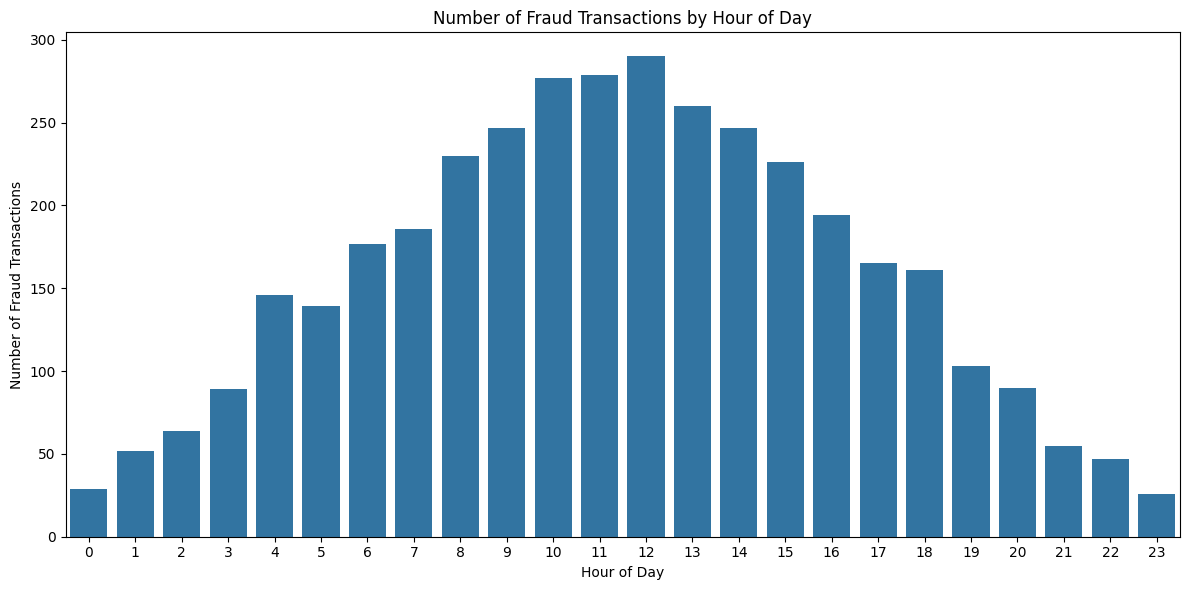

In [20]:
fraud_by_hour = trx.groupby('hour')['tx_fraud'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_hour, x='hour', y='tx_fraud')
plt.title('Number of Fraud Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Fraud Transactions')
plt.tight_layout()
plt.show()

### Fraud rate by hour of day

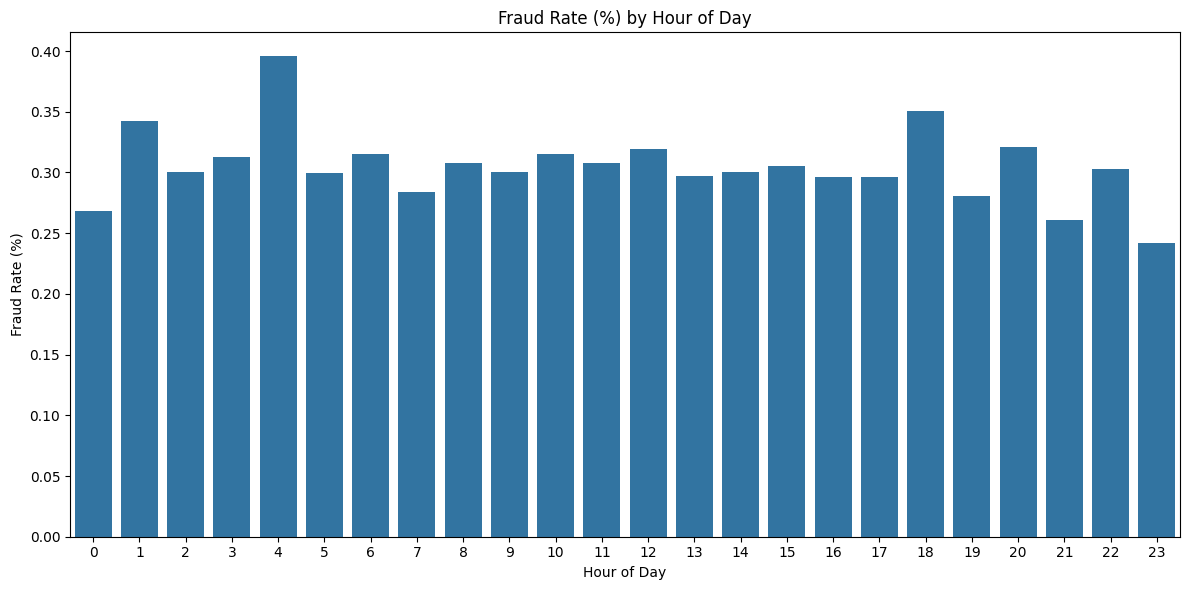

In [21]:
fraud_rate_hour = trx.groupby('hour')['tx_fraud'].agg(['sum', 'count']).reset_index()
fraud_rate_hour['fraud_rate'] = (fraud_rate_hour['sum'] / fraud_rate_hour['count']) * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_rate_hour, x='hour', y='fraud_rate')
plt.title('Fraud Rate (%) by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.tight_layout()
plt.show()

### Frauds by day of the week

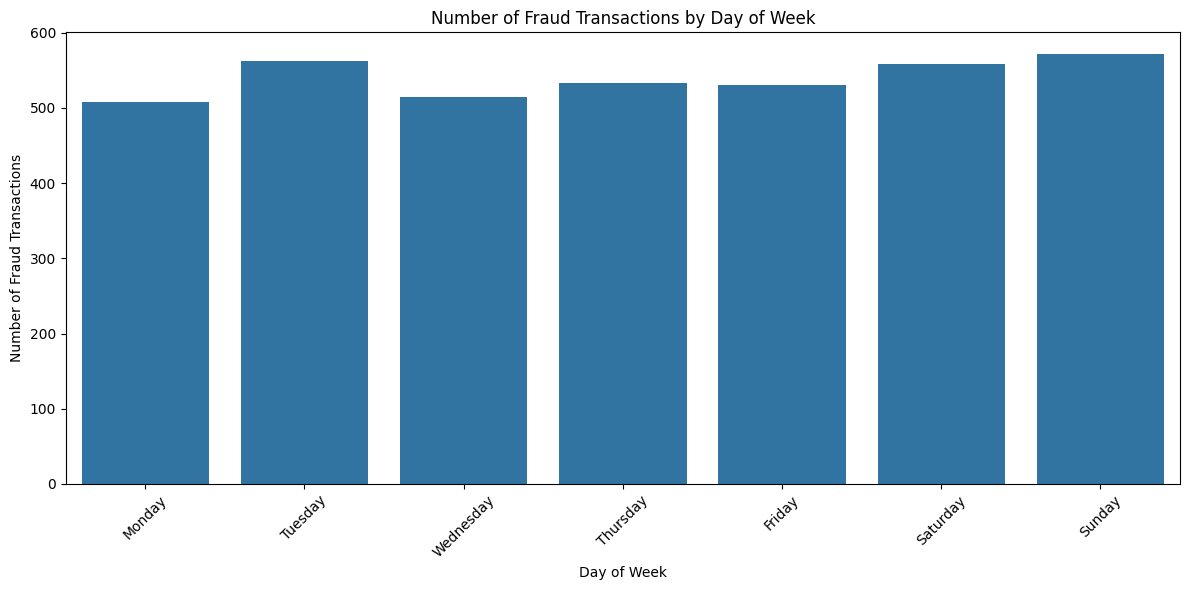

In [22]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fraud_by_day = trx.groupby('day_of_week')['tx_fraud'].sum().reset_index()
fraud_by_day['day_name'] = fraud_by_day['day_of_week'].map(lambda x: day_names[x])

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_day, x='day_name', y='tx_fraud')
plt.title('Number of Fraud Transactions by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Fraud transactions by month

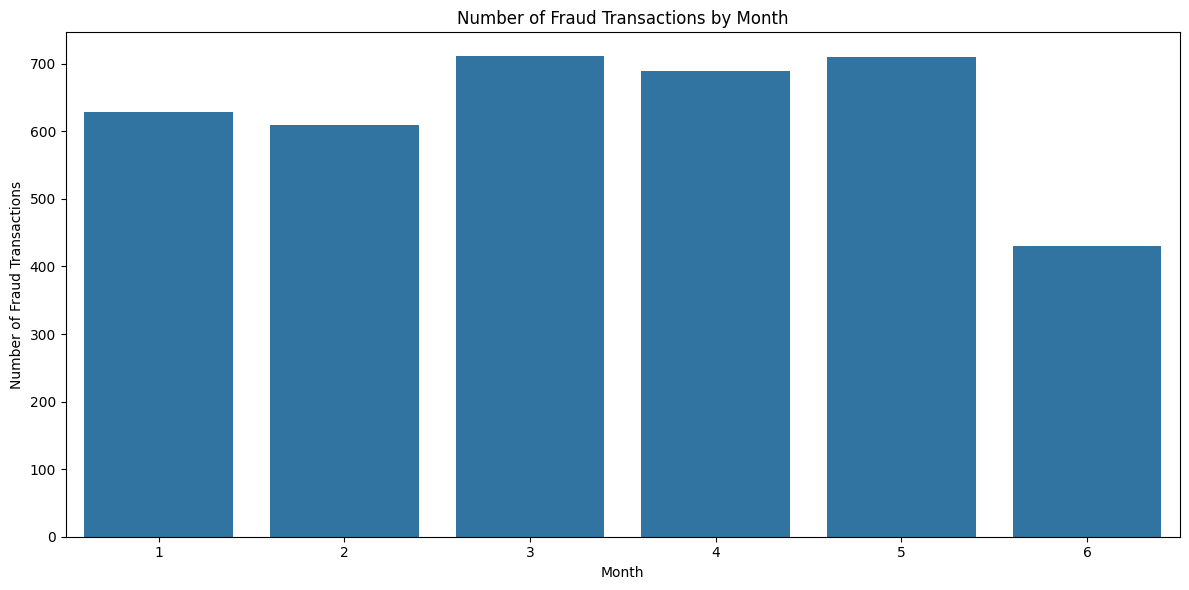

In [23]:
fraud_by_month = trx.groupby('month')['tx_fraud'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_month, x='month', y='tx_fraud')
plt.title('Number of Fraud Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fraud Transactions')
plt.tight_layout()
plt.show()

### Fraud by date attributes

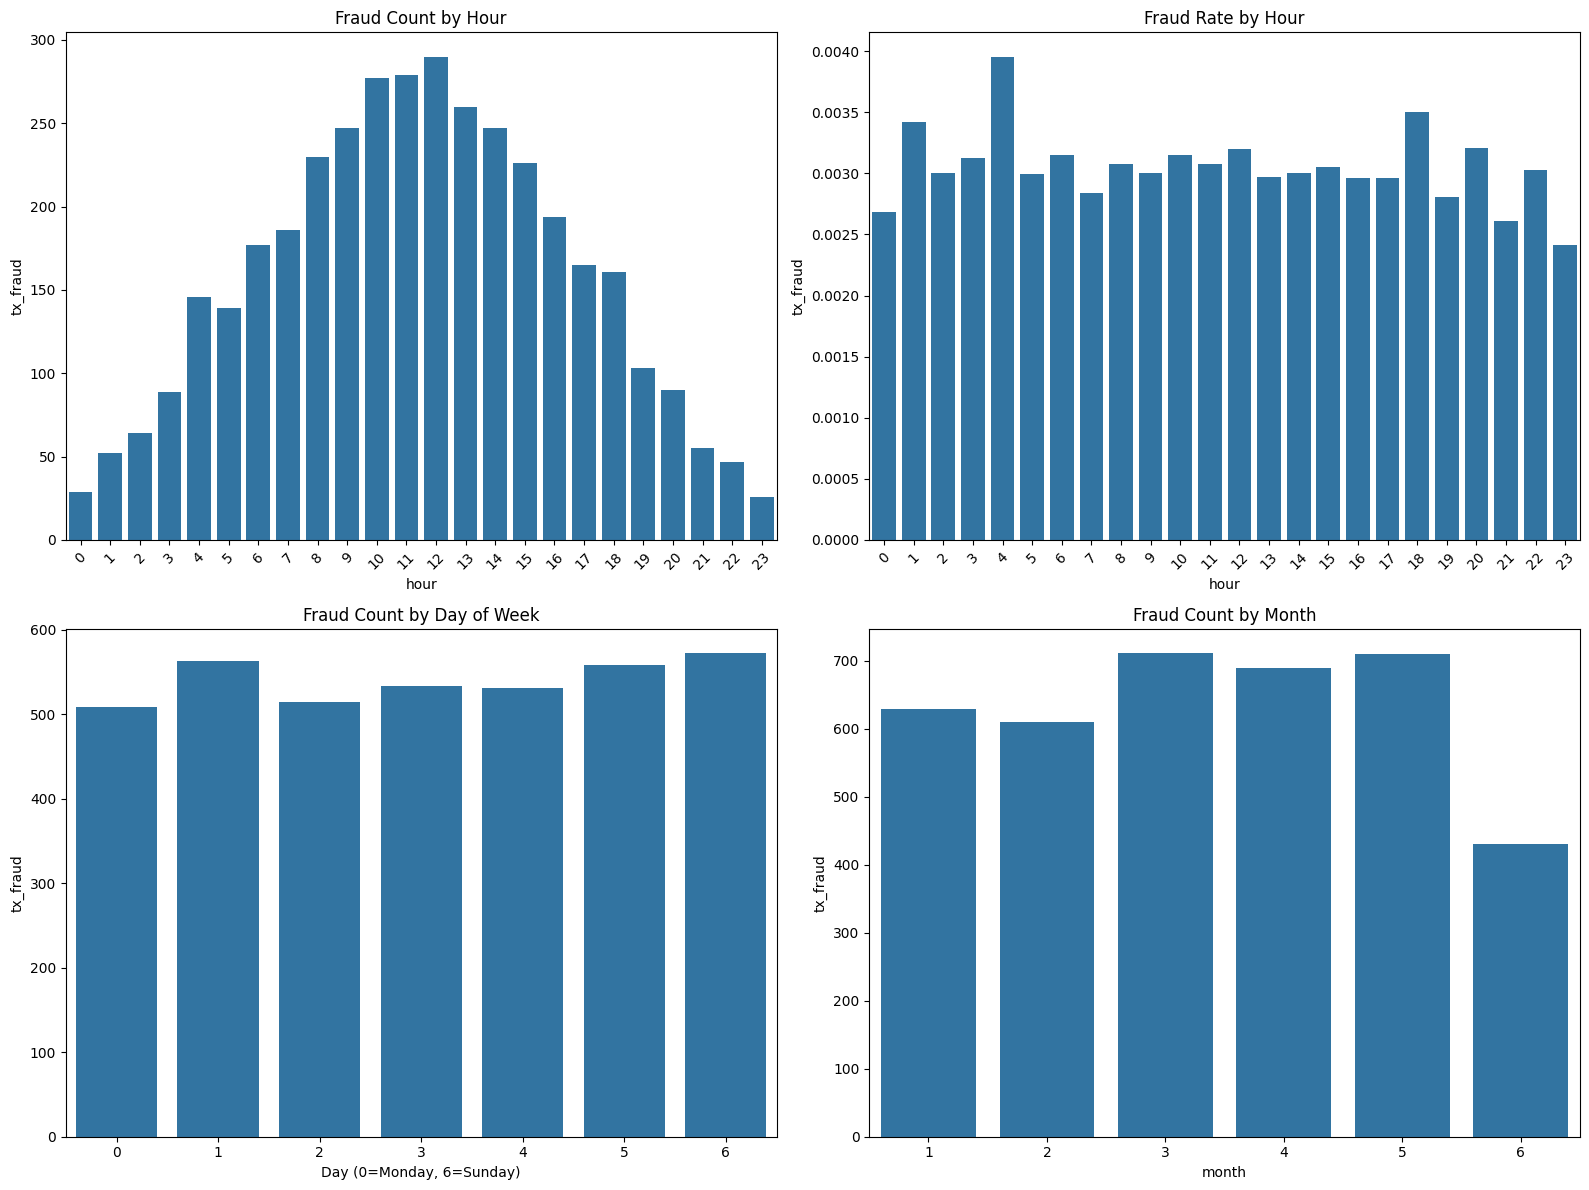

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

fraud_hour = trx.groupby('hour')['tx_fraud'].sum().reset_index()
sns.barplot(data=fraud_hour, x='hour', y='tx_fraud', ax=axes[0,0])
axes[0,0].set_title('Fraud Count by Hour')
axes[0,0].tick_params(axis='x', rotation=45)

fraud_rate_hour = trx.groupby('hour')['tx_fraud'].mean().reset_index()
sns.barplot(data=fraud_rate_hour, x='hour', y='tx_fraud', ax=axes[0,1])
axes[0,1].set_title('Fraud Rate by Hour')
axes[0,1].tick_params(axis='x', rotation=45)

fraud_day = trx.groupby('day_of_week')['tx_fraud'].sum().reset_index()
sns.barplot(data=fraud_day, x='day_of_week', y='tx_fraud', ax=axes[1,0])
axes[1,0].set_title('Fraud Count by Day of Week')
axes[1,0].set_xlabel('Day (0=Monday, 6=Sunday)')

fraud_month = trx.groupby('month')['tx_fraud'].sum().reset_index()
sns.barplot(data=fraud_month, x='month', y='tx_fraud', ax=axes[1,1])
axes[1,1].set_title('Fraud Count by Month')

plt.tight_layout()
plt.show()

### Fraud heatmap: Day of week vs hour

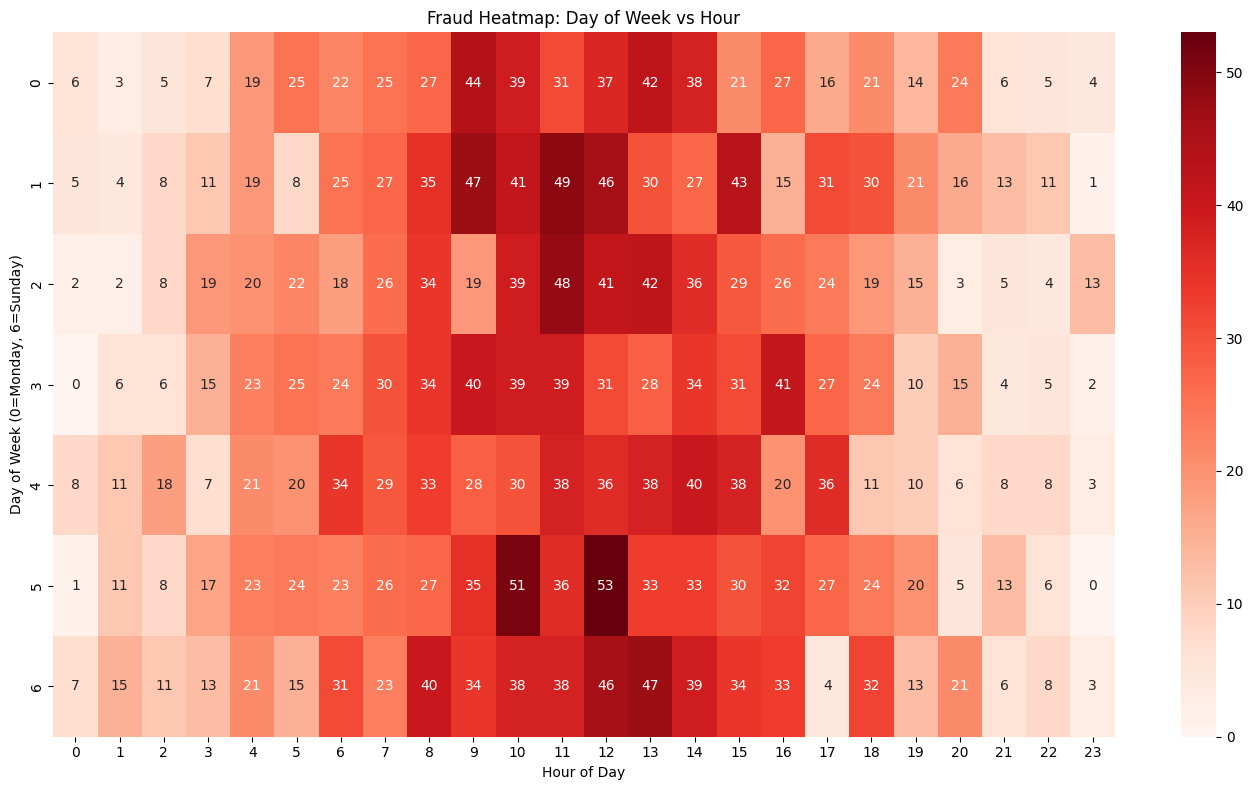

In [25]:
fraud_heatmap = trx.groupby(['day_of_week', 'hour'])['tx_fraud'].sum().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(fraud_heatmap, annot=True, fmt='d', cmap='Reds')
plt.title('Fraud Heatmap: Day of Week vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.tight_layout()
plt.show()

#### Observations

* Most of the frauds happens on Saturday, at 10:00 and 12:00

### Daily fraud over time

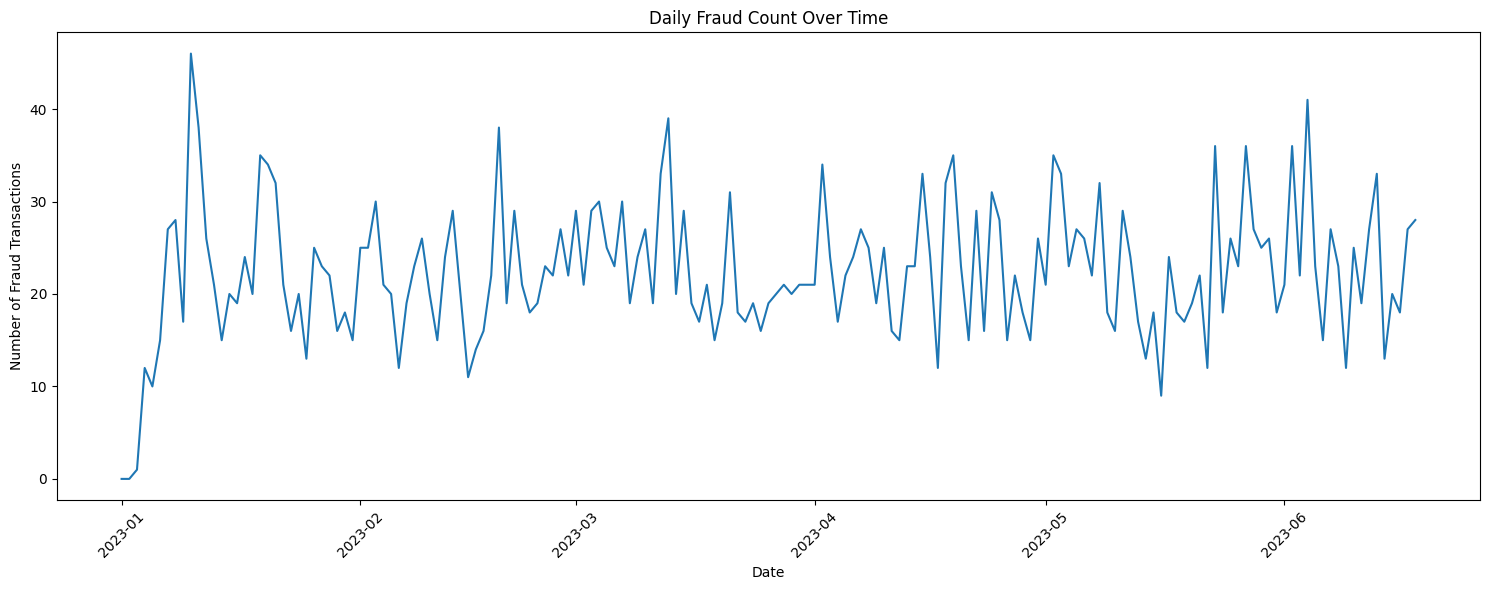

In [26]:
fraud_timeline = trx.copy()
fraud_timeline['date'] = fraud_timeline['tx_datetime'].dt.date
fraud_timeline = fraud_timeline.groupby('date')['tx_fraud'].sum().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(data=fraud_timeline, x='date', y='tx_fraud')
plt.title('Daily Fraud Count Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Fraud and time comparisons

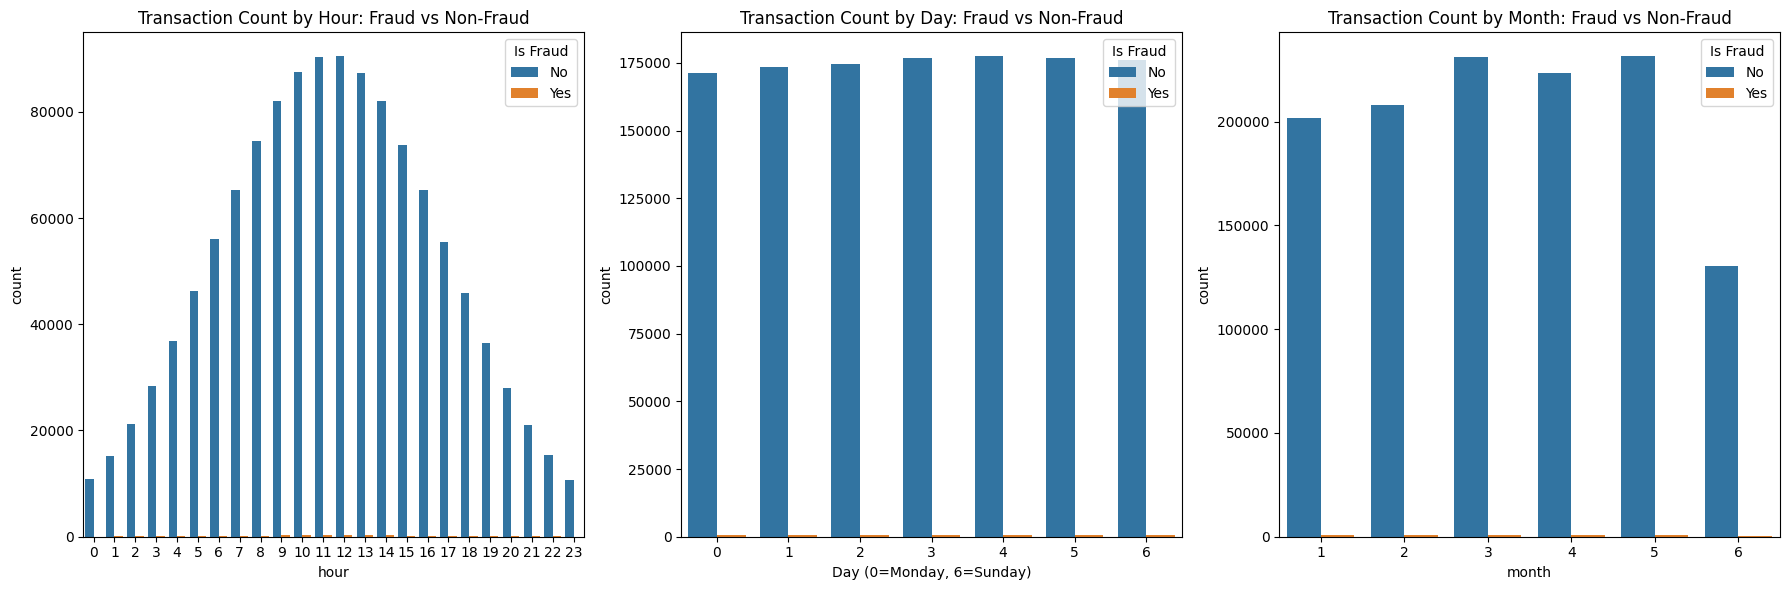

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(data=trx, x='hour', hue='tx_fraud', ax=axes[0])
axes[0].set_title('Transaction Count by Hour: Fraud vs Non-Fraud')
axes[0].legend(title='Is Fraud', labels=['No', 'Yes'])

sns.countplot(data=trx, x='day_of_week', hue='tx_fraud', ax=axes[1])
axes[1].set_title('Transaction Count by Day: Fraud vs Non-Fraud')
axes[1].set_xlabel('Day (0=Monday, 6=Sunday)')
axes[1].legend(title='Is Fraud', labels=['No', 'Yes'])

sns.countplot(data=trx, x='month', hue='tx_fraud', ax=axes[2])
axes[2].set_title('Transaction Count by Month: Fraud vs Non-Fraud')
axes[2].legend(title='Is Fraud', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()